# HMDA Decision Tree Classifier
## Allen Church
### PPOL 565
#### May 4, 2020

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, tree
from sklearn.model_selection import cross_val_score, validation_curve, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import graphviz

In [22]:
df = pd.read_csv("hmda_2018_subset.csv", usecols=['action_taken','state_code', 'derived_race', 'derived_sex', 'loan_amount', 
                                                 'loan_term', 'income', 'debt_to_income_ratio', 'applicant_age', 'tract_minority_population_percent', 'ffiec_msa_md_median_family_income'])
df.isnull().sum()

state_code                             727
derived_race                             0
derived_sex                              0
action_taken                             0
loan_amount                              0
loan_term                              736
income                                5852
debt_to_income_ratio                 16815
applicant_age                            0
tract_minority_population_percent        0
ffiec_msa_md_median_family_income        0
dtype: int64

# Data Cleaning

In [23]:
df = df.dropna()

In [24]:
# action_taken equals 3 (denied) or 1 (approved)
df_apr_deny = df.loc[(df.action_taken==3) | (df.action_taken==1)]

# only selecting values for African American or White
df_apr_deny = df_apr_deny.loc[(df_apr_deny.derived_race=='White') | (df_apr_deny.derived_race=='Black or African American')]

In [25]:
# removing exempt value from debt_income ratio and loan_term, as these are esentially NAs
df_apr_deny = df_apr_deny[df_apr_deny["debt_to_income_ratio"].str.contains('Exempt')==False]
df_apr_deny = df_apr_deny[df_apr_deny["loan_term"].str.contains('Exempt')==False]

In [26]:
len(df_apr_deny)

25540

## Label Encoding so that $0$ == Approved, $1$ == Denied

In [27]:
y = df_apr_deny['action_taken']
lb = LabelEncoder()
lb.fit(y)
print(lb.classes_)
y = lb.transform(y)

[1 3]


## Creating Feature Matrix

In [28]:
X = df_apr_deny.drop(['action_taken'], axis=1)

In [29]:
# below transforms derived_race so that white = 1 and African American = 0
lb.fit(X["derived_race"])
X["derived_race"] = lb.transform(X["derived_race"])

In [30]:
# encoding multiple class variables into dummy variables
X = pd.get_dummies(X, columns=["state_code","derived_sex","applicant_age"])
X.head()

,derived_race,loan_amount,loan_term,income,debt_to_income_ratio,tract_minority_population_percent,ffiec_msa_md_median_family_income,state_code_AK,state_code_AL,state_code_AR,...,derived_sex_Male,derived_sex_Sex Not Available,applicant_age_25-34,applicant_age_35-44,applicant_age_45-54,applicant_age_55-64,applicant_age_65-74,applicant_age_8888,applicant_age_<25,applicant_age_>74
0,1,195000,360,78.0,60,14.04,82400,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,1,205000,360,64.0,45,11.80,76600,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,1,105000,361,41.0,55,8.64,74800,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,125000,20,142.0,37,7.71,60500,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,275000,360,85.0,41,77.77,75600,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [31]:
# renaming columns for clarity and visuals below
X = X.rename(columns={'derived_race': 'Derived Race', 'loan_amount': 'Loan Amount',
                 'loan_term':'Loan Term', 'income':'Income', 'debt_to_income_ratio':'Debt to Income Ratio',
                  'tract_minority_population_percent':'Minority Population %',
                 'ffiec_msa_md_median_family_income':'Median Family Income',
                     'applicant_age_25-34':'Applicant Age: 25-34','state_code_NY':'State: NY',
                     'state_code_WY':'State: WY', 'state_code_KY':'State: KY', 'derived_sex_Joint':
                      'Sex: Joint'})

# Splitting into Training/Testing Sets

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Decision Tree Classifier

In [33]:
# max depth 5 produces best fit and most interpretable tree
model = tree.DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [34]:
# transposing feature_importances into top 5 for graphing below
coef = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.feature_importances_))], axis = 1)
coef.columns = ['Variable', 'Proportion']
coef = coef.nlargest(5, 'Proportion')
coef = coef.round(3)

# Decision Tree Graphic

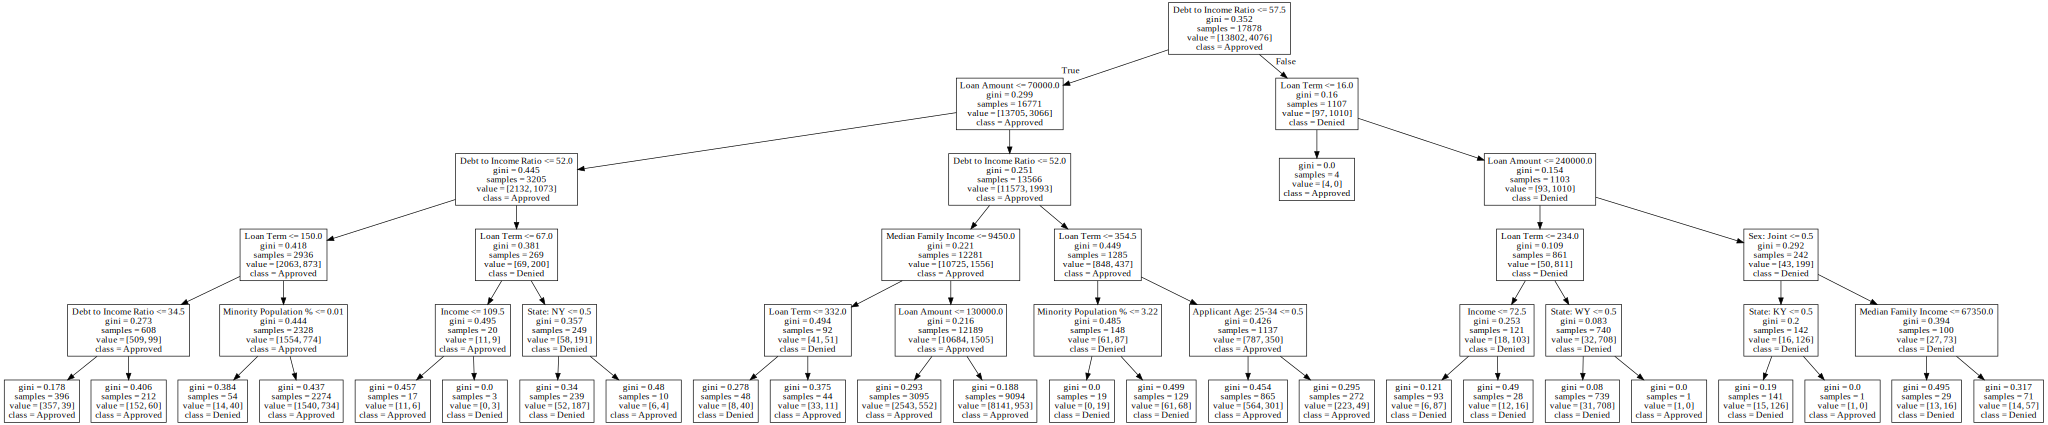

In [35]:
# print decision tree and save to file
tree_data = tree.export_graphviz(model, out_file=None,
                               feature_names=X.columns,
                               class_names=['Approved', 'Denied'])
graph = graphviz.Source(tree_data)
graph.render("hmda_tree")
graph

# Visualizing Feature Importance

In [36]:
import plotly.express as px
fig = px.bar(coef, x="Proportion", y="Variable", orientation='h', height=1000,
            title='Variable Importance').update_yaxes(categoryorder="total ascending")

fig.show()

# Validating Model Score

In [37]:
round(np.mean(cross_val_score(model, X_test, y_test,cv=5)),3)

0.827

# Confusion Matrix for Decision Tree

In [38]:
confusion_matrix(y, model.predict(X))

array([[19351,   348],
       [ 3898,  1943]])

In [39]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90     19699
           1       0.85      0.33      0.48      5841

    accuracy                           0.83     25540
   macro avg       0.84      0.66      0.69     25540
weighted avg       0.84      0.83      0.80     25540

